<a href="https://colab.research.google.com/github/sysyJEON/class_ai4ml/blob/main/ml_guide/ch05_Regression_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 5.10 회귀 실습 - 캐글 주택 가격: 고급 회귀 기법

캐글 주택 가격: 고급 회귀 기법(House Prices: Advanced Regression Techniques)
- https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data?select=train.csv
- 미국 아이오와 주의 에임스(Ames) 지방의 주택 가격 정보
- 성능평가는 RMSLE(Root Mean Squared Log Error): 실제 값과 예측값의 오류를 로그 변환한 뒤 RMSE 적용

### 데이터 사전 처리(Preprocessing)

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

house_df_org = pd.read_csv('/content/drive/MyDrive/데이터/house_price.csv')  # 원본
house_df = house_df_org.copy()  # 복사해서 데이터 가공
house_df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


- Target 값은 맨 마지막 칼럼인 SalePrice

In [24]:
print('데이터 세트의 Shape:', house_df.shape) # 데이터 세트 전체 크기
print('\n전체 feature 들의 type \n',house_df.dtypes.value_counts()) # 칼럼 타입
isnull_series = house_df.isnull().sum()
print('\nNull 컬럼과 그 건수:\n ', isnull_series[isnull_series > 0].sort_values(ascending=False)) # Null 있는 칼럼과 그 건수 내림차순으로 출력

데이터 세트의 Shape: (1460, 81)

전체 feature 들의 type 
 object     43
int64      35
float64     3
Name: count, dtype: int64

Null 컬럼과 그 건수:
  PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
Electrical         1
dtype: int64


- 데이터 세트: 1460개의 레코드와 81개 피처(타깃 제외 80개)
- 피처 타입: 문자형, 숫자형
- Null 값 많음

타깃 값 분포도가 정규 분포인지 확인

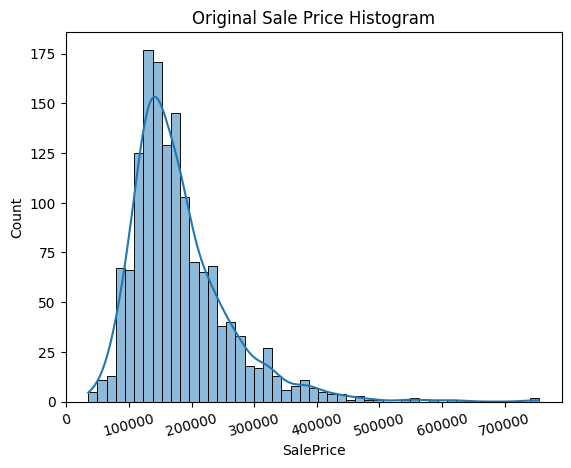

In [25]:
plt.title('Original Sale Price Histogram')
plt.xticks(rotation=15)
sns.histplot(house_df['SalePrice'], kde=True)
plt.show()

- 왼쪽으로 치우친 형태로 정규 분포에서 벗어남

정규 분포 형태 변환 위해 로그 변환(Log Transformation) 적용
- 넘파이의 `log1p()`로그 변환한 결괏값을 기반으로 학습
  -  `log()`의 오버플로/언더플로 문제 해결
  -  log(x) -> log(1+x)로 변환되므로 x값이 0이 되더라도 log(0)인 무한대가 되지 않고 log(1)인 0이 됨
- 예측 시에는 다시 결괏값을 `expm1()`로 환원
  - log1p()로 변환된 값이 원래 스케일로 복원됨

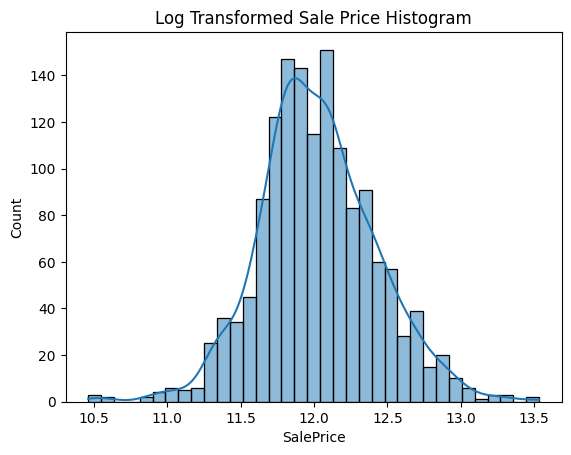

In [26]:
plt.title('Log Transformed Sale Price Histogram')
log_SalePrice = np.log1p(house_df['SalePrice'])
sns.histplot(log_SalePrice, kde=True)
plt.show()

- SalePrice를 로그 변환해 정규 분포 형태로 결괏값이 분포함

SalePrice를 로그 변환한 뒤 DataFrame에 반영

In [27]:
# SalePrice 로그 변환
original_SalePrice = house_df['SalePrice']
house_df['SalePrice'] = np.log1p(house_df['SalePrice'])

# Null 이 너무 많은 컬럼들과 불필요한 컬럼 삭제
house_df.drop(['Id','PoolQC' , 'MiscFeature', 'Alley', 'Fence','FireplaceQu'], axis=1 , inplace=True) # 'Id'는 단순 식별자

In [28]:
house_df.columns # 컬럼 삭제 확인

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'GarageType', 'GarageYrBlt', 'GarageFinish',
       'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive',
       'WoodDeckSF', 'OpenPorchSF'

Null 값 많지 않은 피처는 숫자형의 경우 Null 값을 평균값으로 대체

In [32]:
# mean()을 DataFrame에 사용하면 자동으로 숫자 컬럼에 대해서만 적용되었는데
# 버전 업그레이드 되면서 더 이상 이 방식으로는 적용되지 않음
# TypeError: can only concatenate str (not "int") to str

# object가 아닌 number 타입을 별도 리스트로 추출
num_columns = house_df.dtypes[house_df.dtypes != 'object'].index.to_list()

# number 타입 컬럼들에 대해서 Null컬럼들은 평균값으로 대체
house_df[num_columns].fillna(house_df[num_columns].mean(),inplace=True)

In [33]:
# Null 값이 있는 피처명과 타입을 추출
null_column_count = house_df.isnull().sum()[house_df.isnull().sum() > 0]
print('## Null 피처의 Type :\n', house_df.dtypes[null_column_count.index])

## Null 피처의 Type :
 LotFrontage     float64
MasVnrType       object
MasVnrArea      float64
BsmtQual         object
BsmtCond         object
BsmtExposure     object
BsmtFinType1     object
BsmtFinType2     object
Electrical       object
GarageType       object
GarageYrBlt     float64
GarageFinish     object
GarageQual       object
GarageCond       object
dtype: object


In [37]:
# 아직 Null 값 있는 숫자형 피처 평균값으로 직접 대체
house_df['LotFrontage'].fillna(house_df['LotFrontage'].mean(),inplace=True)
house_df['MasVnrArea'].fillna(house_df['MasVnrArea'].mean(),inplace=True)
house_df['GarageYrBlt'].fillna(house_df['GarageYrBlt'].mean(),inplace=True)

In [38]:
# Null 값이 있는 피처명과 타입을 추출
null_column_count = house_df.isnull().sum()[house_df.isnull().sum() > 0]
print('## Null 피처의 Type :\n', house_df.dtypes[null_column_count.index])

## Null 피처의 Type :
 MasVnrType      object
BsmtQual        object
BsmtCond        object
BsmtExposure    object
BsmtFinType1    object
BsmtFinType2    object
Electrical      object
GarageType      object
GarageFinish    object
GarageQual      object
GarageCond      object
dtype: object


- 이제 문자형 피처를 제외하고는 Null 값이 없음

문자형 피처는 모두 원-핫 인코딩으로 변환
- `get_dummiews()`이용
  - 자동으로 문자열 피처를 원-핫 인코딩 변환하면서 Null 값은 모든 ㅣㄴ코딩 값이 0으로 변환됨
- 인코딩 후 칼럼 증가

In [39]:
print('get_dummies() 수행 전 데이터 Shape:', house_df.shape)
house_df_ohe = pd.get_dummies(house_df)
print('get_dummies() 수행 후 데이터 Shape:', house_df_ohe.shape)

null_column_count = house_df_ohe.isnull().sum()[house_df_ohe.isnull().sum() > 0]
print('## Null 피처의 Type :\n', house_df_ohe.dtypes[null_column_count.index])

get_dummies() 수행 전 데이터 Shape: (1460, 75)
get_dummies() 수행 후 데이터 Shape: (1460, 270)
## Null 피처의 Type :
 Series([], dtype: object)


- 피처가 75개 -> 271개
- Null 값 가진 피처 존재하지 않음

### 선형 회귀 모델의 학습/예측/평가

- 예측 평가 RMSLE 이용하는데 이미 타깃 값 SalePrice가 로그 변환됨
- 예측값 역시 로그 변환된 SalePrice 값 기반으로 예측하므로 예측 결과 오류에 RMSE만 적용하면 RMSLE가 자동으로 측정됨

RMSE 계산 함수 생성

In [40]:
# 단일 모델의 RMSE 값
def get_rmse(model):
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test , pred)
    rmse = np.sqrt(mse)
    print('{0} 로그 변환된 RMSE: {1}'.format(model.__class__.__name__,np.round(rmse, 3)))
    return rmse

# 여러 모델의 RMSE 값 반환
def get_rmses(models):
    rmses = [ ]
    for model in models:
        rmse = get_rmse(model)
        rmses.append(rmse)
    return rmses

선형 회귀 모델 학습, 예측, 평가

In [41]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice',axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

# LinearRegression, Ridge, Lasso 학습, 예측, 평가
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)

ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)

lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

LinearRegression 로그 변환된 RMSE: 0.132
Ridge 로그 변환된 RMSE: 0.127
Lasso 로그 변환된 RMSE: 0.176


[0.13183184688250854, 0.1274058283626615, 0.17628250556471403]

- 라쏘 회귀 경우 타 회귀 방식보다 회귀 성능 떨어짐(최적 하이퍼 파라미터 튜닝 필요)

피처별 회귀 계수 시각화

In [42]:
# 피처 많으니 회귀 계수 값의 상위 10, 하위 10개의 피처명과 그 회귀 계수 값을 가지는 판다스 Series 객체 반환하는 함수

def get_top_bottom_coef(model):
    # coef_ 속성을 기반으로 Series 객체를 생성. index는 컬럼명.
    coef = pd.Series(model.coef_, index=X_features.columns)

    # + 상위 10개 , - 하위 10개 coefficient 추출하여 반환.
    coef_high = coef.sort_values(ascending=False).head(10)
    coef_low = coef.sort_values(ascending=False).tail(10)
    return coef_high, coef_low

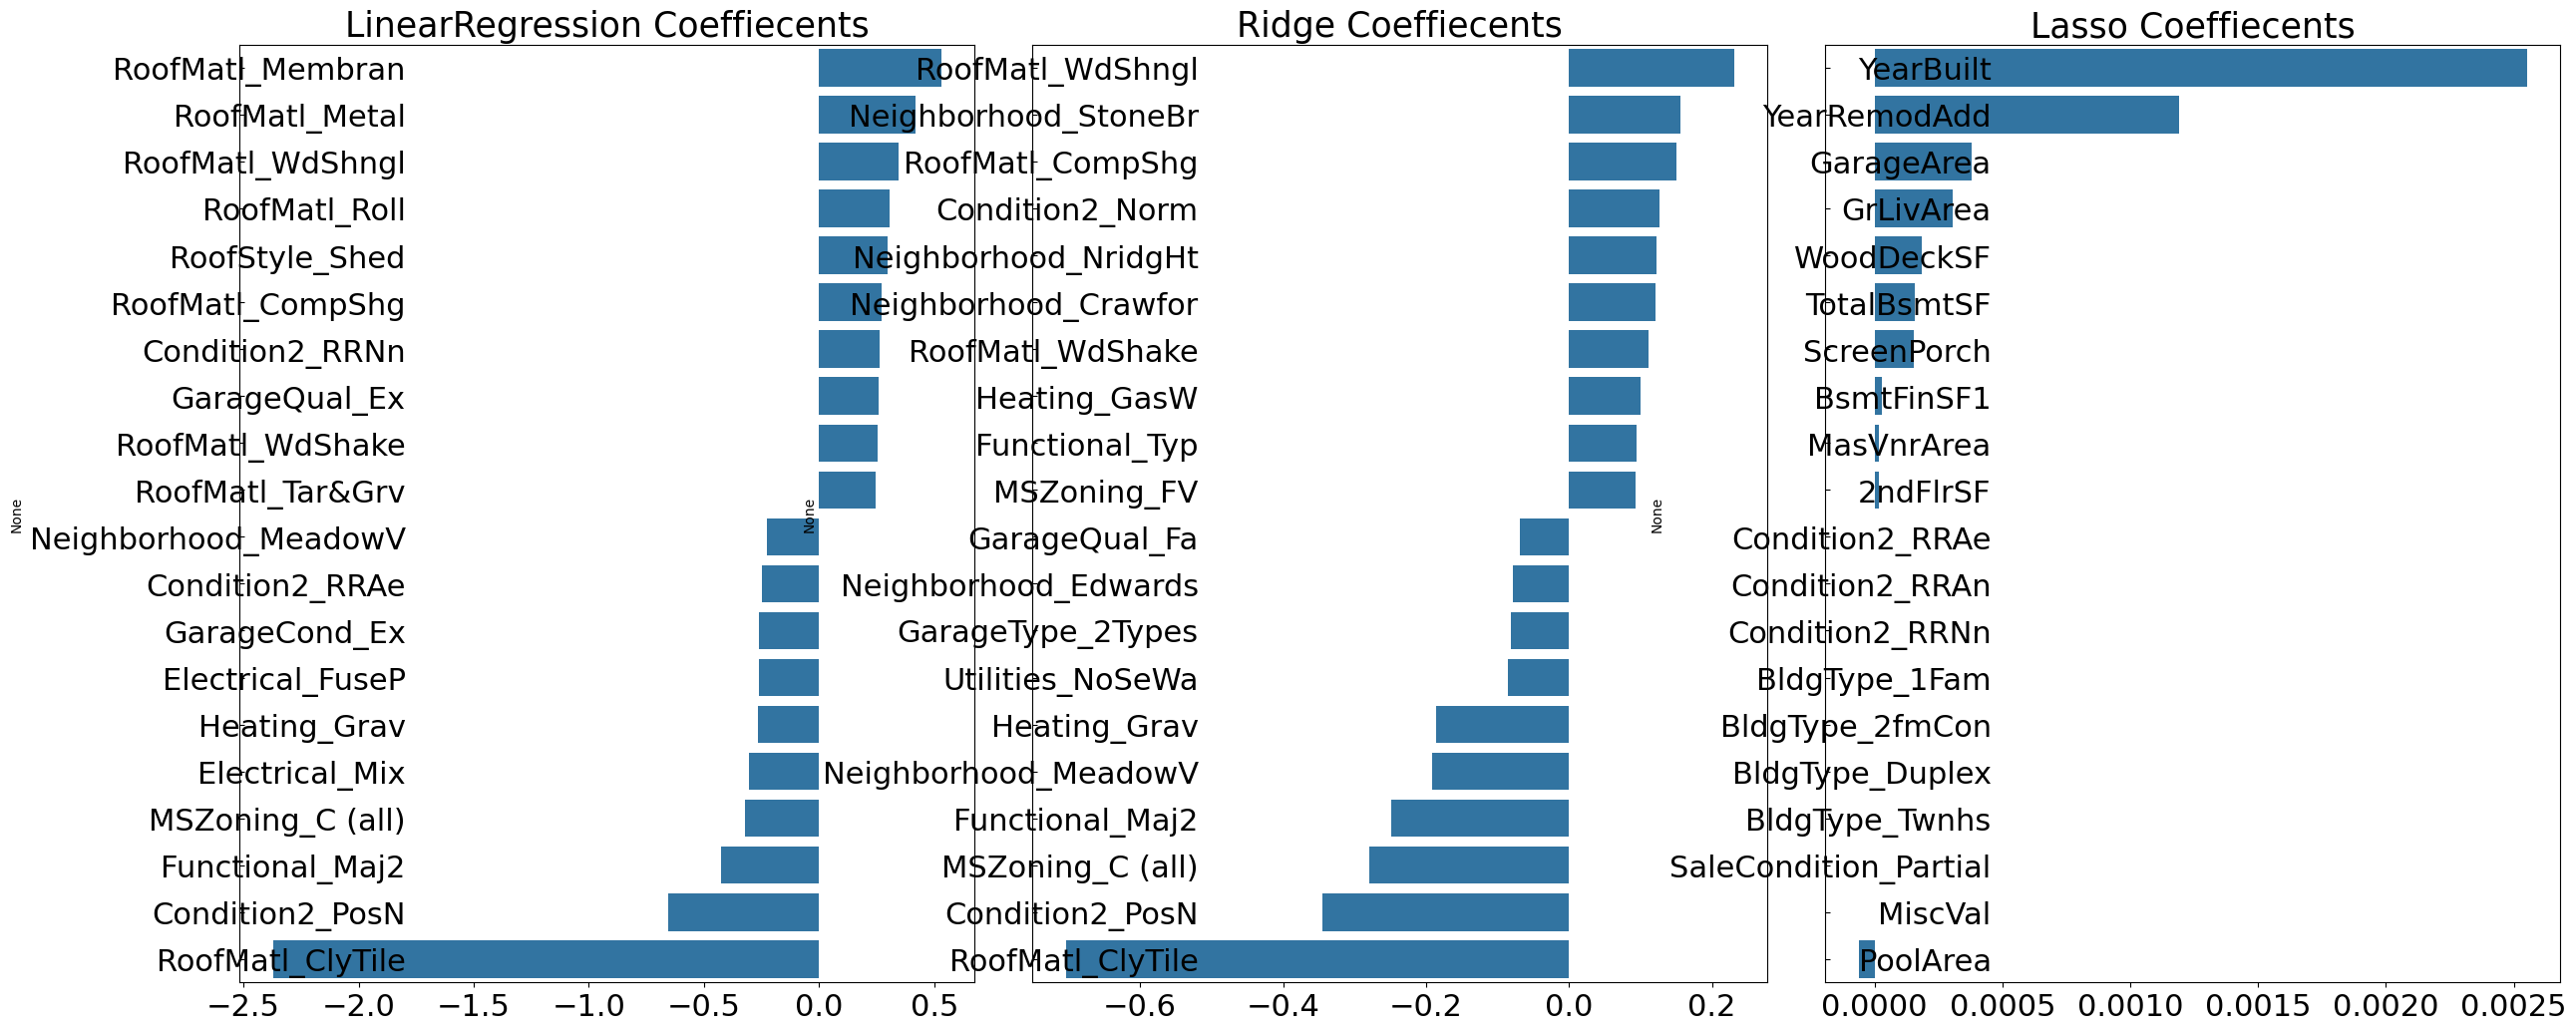

In [43]:
# 모델별 회귀 계수 시각화

def visualize_coefficient(models):
    # 3개 회귀 모델의 시각화를 위해 3개의 컬럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize=(24,10),nrows=1, ncols=3)
    fig.tight_layout()
    # 입력인자로 받은 list객체인 models에서 차례로 model을 추출하여 회귀 계수 시각화.
    for i_num, model in enumerate(models):
        # 상위 10개, 하위 10개 회귀 계수를 구하고, 이를 판다스 concat으로 결합.
        coef_high, coef_low = get_top_bottom_coef(model)
        coef_concat = pd.concat( [coef_high , coef_low] )
        # 순차적으로 ax subplot에 barchar로 표현. 한 화면에 표현하기 위해 tick label 위치와 font 크기 조정.
        axs[i_num].set_title(model.__class__.__name__+' Coeffiecents', size=25)
        axs[i_num].tick_params(axis="y",direction="in", pad=-120)
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=coef_concat.values, y=coef_concat.index , ax=axs[i_num])

# 앞 예제에서 학습한 lr_reg, ridge_reg, lasso_reg 모델의 회귀 계수 시각화.
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

- LinearRegression과 Ridge의 경우 회귀 계수가 유사한 형태로 분포
- 라쏘는 다른 두 모델과 다른 회귀 계수 형태
- 라쏘(Lasso)는 전체적으로 회귀 계수 값이 매우 작고, YearBuilt가 가장 큼

혹시 학습 데이터의 데이터 분할에 문제가 있어서인지 확인
- 학습과 테스트 데이터 세트를 `train_test_split()`으로 분할하지 않고 전체 데이터 세트인 `X_features`와 `y_target`을 5개의 교차 검증 폴드 세트로 분할해 평균 RMSE 측정

In [44]:
from sklearn.model_selection import cross_val_score

def get_avg_rmse_cv(models):
    for model in models:
        # 분할하지 않고 전체 데이터로 cross_val_score( ) 수행. 모델별 CV RMSE값과 평균 RMSE 출력
        rmse_list = np.sqrt(-cross_val_score(model, X_features, y_target,
                                             scoring="neg_mean_squared_error", cv = 5))
        rmse_avg = np.mean(rmse_list)
        print('\n{0} CV RMSE 값 리스트: {1}'.format( model.__class__.__name__, np.round(rmse_list, 3)))
        print('{0} CV 평균 RMSE 값: {1}'.format( model.__class__.__name__, np.round(rmse_avg, 3)))

# 앞 예제에서 학습한 lr_reg, ridge_reg, lasso_reg 모델의 CV RMSE값 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_avg_rmse_cv(models)


LinearRegression CV RMSE 값 리스트: [0.135 0.165 0.167 0.111 0.198]
LinearRegression CV 평균 RMSE 값: 0.155

Ridge CV RMSE 값 리스트: [0.117 0.154 0.142 0.117 0.189]
Ridge CV 평균 RMSE 값: 0.144

Lasso CV RMSE 값 리스트: [0.161 0.204 0.177 0.181 0.265]
Lasso CV 평균 RMSE 값: 0.198


- 여전히 라쏘의 경우 릿지 모델보다 성능이 떨어짐
- 데이터 분할 문제가 아니다.

릿지와 라쏘 모델에 alpha 하이퍼 파라미터 튜닝

In [45]:
from sklearn.model_selection import GridSearchCV

# 모델과 하이퍼 파라미터 딕셔너리 객체를 받아 최적화 작업의 결과를 표시하는 함수
def print_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid=params,
                              scoring='neg_mean_squared_error', cv=5)
    grid_model.fit(X_features, y_target)
    rmse = np.sqrt(-1* grid_model.best_score_)
    print('{0} 5 CV 시 최적 평균 RMSE 값: {1}, 최적 alpha:{2}'.format(model.__class__.__name__,
                                        np.round(rmse, 4), grid_model.best_params_))
    return grid_model.best_estimator_

ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }
best_rige = print_best_params(ridge_reg, ridge_params)
best_lasso = print_best_params(lasso_reg, lasso_params)


Ridge 5 CV 시 최적 평균 RMSE 값: 0.1418, 최적 alpha:{'alpha': 12}
Lasso 5 CV 시 최적 평균 RMSE 값: 0.142, 최적 alpha:{'alpha': 0.001}


- 라쏘 모델 alpha 0.001에서 최적 평균 RMSE 0.142
- alpha 값 최적화 이후 예측 성능 많이 좋아짐(0.176 -> 0.198 -> 0.142)

선형 모델에 최적 alpha 값 설정한 뒤, `train_test_split()`으로 분할된 학습 데이터와 테스트 데이터 이용해 모델 학습/예측/평가 수행 후 모델별 회귀 계수 시각화

LinearRegression 로그 변환된 RMSE: 0.132
Ridge 로그 변환된 RMSE: 0.124
Lasso 로그 변환된 RMSE: 0.12


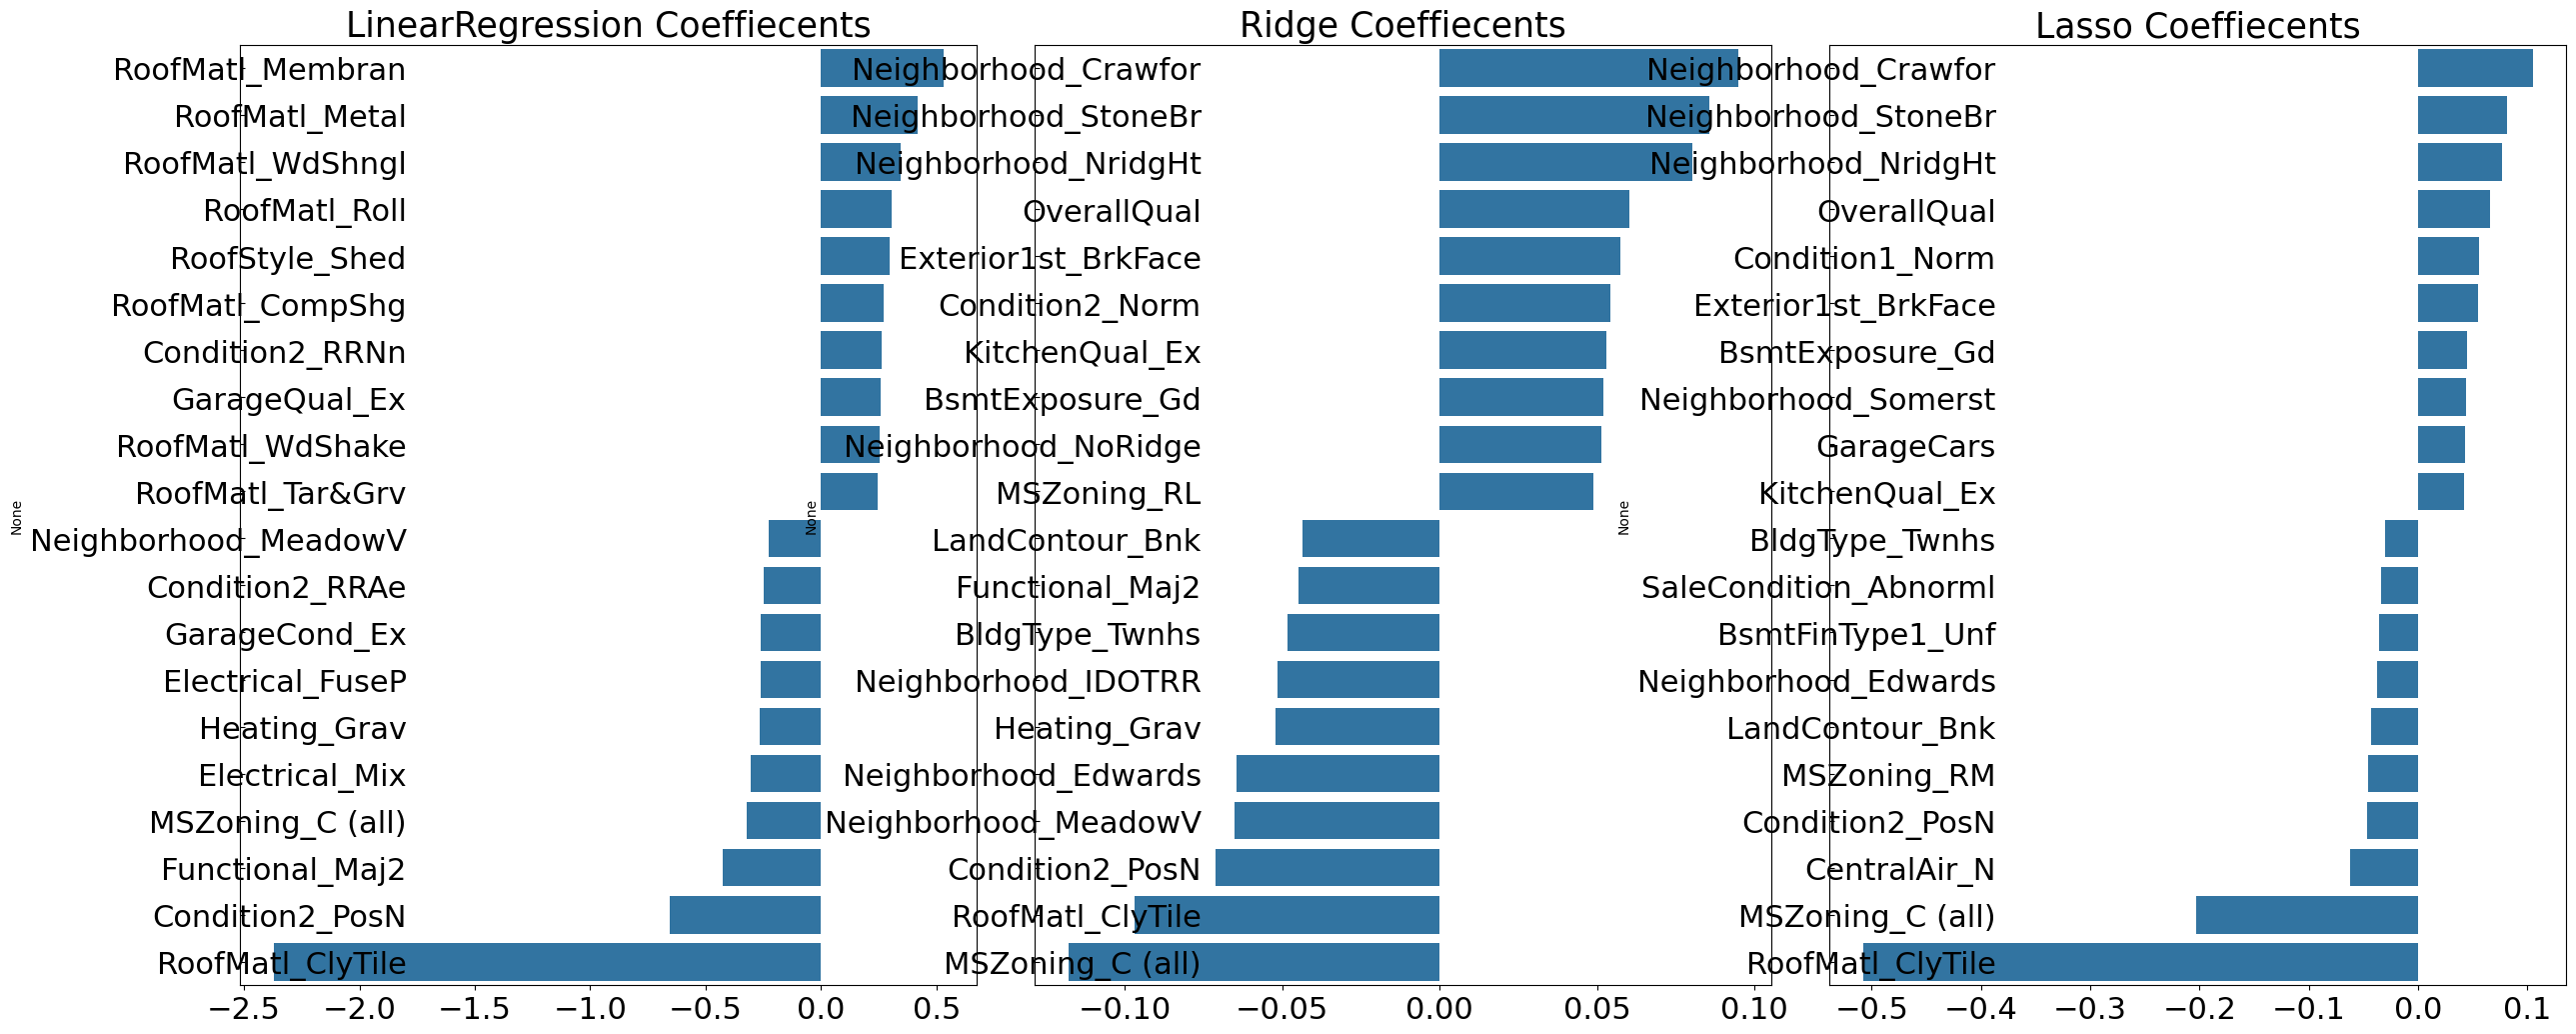

In [46]:
# 앞의 최적화 alpha값으로 학습데이터로 학습, 테스트 데이터로 예측 및 평가 수행.
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=12)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

# 모든 모델의 회귀 계수 시각화
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

- alpha 값 최적화 적용 후 테스트 데이터 세트의 예측 성능 좋아짐
- 릿지와 라쏘 모델 회귀 계수도 비슷해짐
- 다만 라쏘 모델이 릿지에 비해 회귀 계수 값이 작음

추가적인 데이터 세트 가공으로 모델 튜닝 진행
- 피처 데이터 세트의 데이터 분포도
- 이상치(Outlier) 데이터 처리

피처 데이터 세트 분포도 확인
- 예제 처음에서 타깃 데이터 세트의 데이터 분포도의 왜곡 확인
- 피처 데이터 세트의 경우도 지나치게 왜곡된 피처 존재할 경우 회귀 에측 성능 저하

사이파이 stats 모듈의 `skew()` 함수
- 칼럼의 데이터 세트의 왜곡된 정도 쉽게 추출
- 보통 반환 값이 1 이상인 경우 왜곡 정도가 높다고 판단
- 1 이상의 값을 반환하는 피처만 추출해 왜곡 정도 완화하기 위해 로그 변환 적용
- 숫자형 칼럼 데이터 세트의 apply lambda 식 skew()를 호출해 숫자형 피처의 왜곡 정도 구함

주의할 점
- 적용하는 숫자형 피처에서 원-핫 인코딩된 카테고리 숫자형 피처는 제외
- `house_df_ohe`이 아닌 원-핫 인코딩이 적용되지 않은 `house_df` 사용

In [47]:
from scipy.stats import skew

# object가 아닌 숫자형 피처의 칼럼 index 객체 추출.
features_index = house_df.dtypes[house_df.dtypes != 'object'].index
# house_df에 칼럼 index를 [ ]로 입력하면 해당하는 칼럼 데이터 세트 반환. apply lambda로 skew( ) 호출
skew_features = house_df[features_index].apply(lambda x : skew(x))
# skew(왜곡) 정도가 1 이상인 칼럼만 추출.
skew_features_top = skew_features[skew_features > 1]
print(skew_features_top.sort_values(ascending=False))

MiscVal          24.451640
PoolArea         14.813135
LotArea          12.195142
3SsnPorch        10.293752
LowQualFinSF      9.002080
KitchenAbvGr      4.483784
BsmtFinSF2        4.250888
ScreenPorch       4.117977
BsmtHalfBath      4.099186
EnclosedPorch     3.086696
MasVnrArea        2.673661
LotFrontage       2.382499
OpenPorchSF       2.361912
BsmtFinSF1        1.683771
WoodDeckSF        1.539792
TotalBsmtSF       1.522688
MSSubClass        1.406210
1stFlrSF          1.375342
GrLivArea         1.365156
dtype: float64


In [48]:
house_df[skew_features_top.index] = np.log1p(house_df[skew_features_top.index]) # house_df_ohe이 아닌 house_df 사용

In [49]:
# Skew가 높은 피처들을 로그 변환 했으므로 다시 원-핫 인코딩 적용 및 피처/타겟 데이터 셋 생성
house_df_ohe = pd.get_dummies(house_df)
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice',axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

# 피처들을 로그 변환 후 다시 최적 하이퍼 파라미터와 RMSE 출력
ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }
best_ridge = print_best_params(ridge_reg, ridge_params)
best_lasso = print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값: 0.1275, 최적 alpha:{'alpha': 10}
Lasso 5 CV 시 최적 평균 RMSE 값: 0.1252, 최적 alpha:{'alpha': 0.001}


- 릿지 모델 최적 alpha값 12->10
- 5 폴드 교차 검증 평균 RMSE값 향상
  - 릿지: 0.1418 -> 0.1275
  - 라쏘: 0.142 -> 0.1252

다시 `train_test_split()`으로 분할된 학습 데이터와 테스트 데이터를 이용해 모델의 학습/예측/평가 및 모델별 회귀 계수 시각화

LinearRegression 로그 변환된 RMSE: 0.128
Ridge 로그 변환된 RMSE: 0.122
Lasso 로그 변환된 RMSE: 0.119


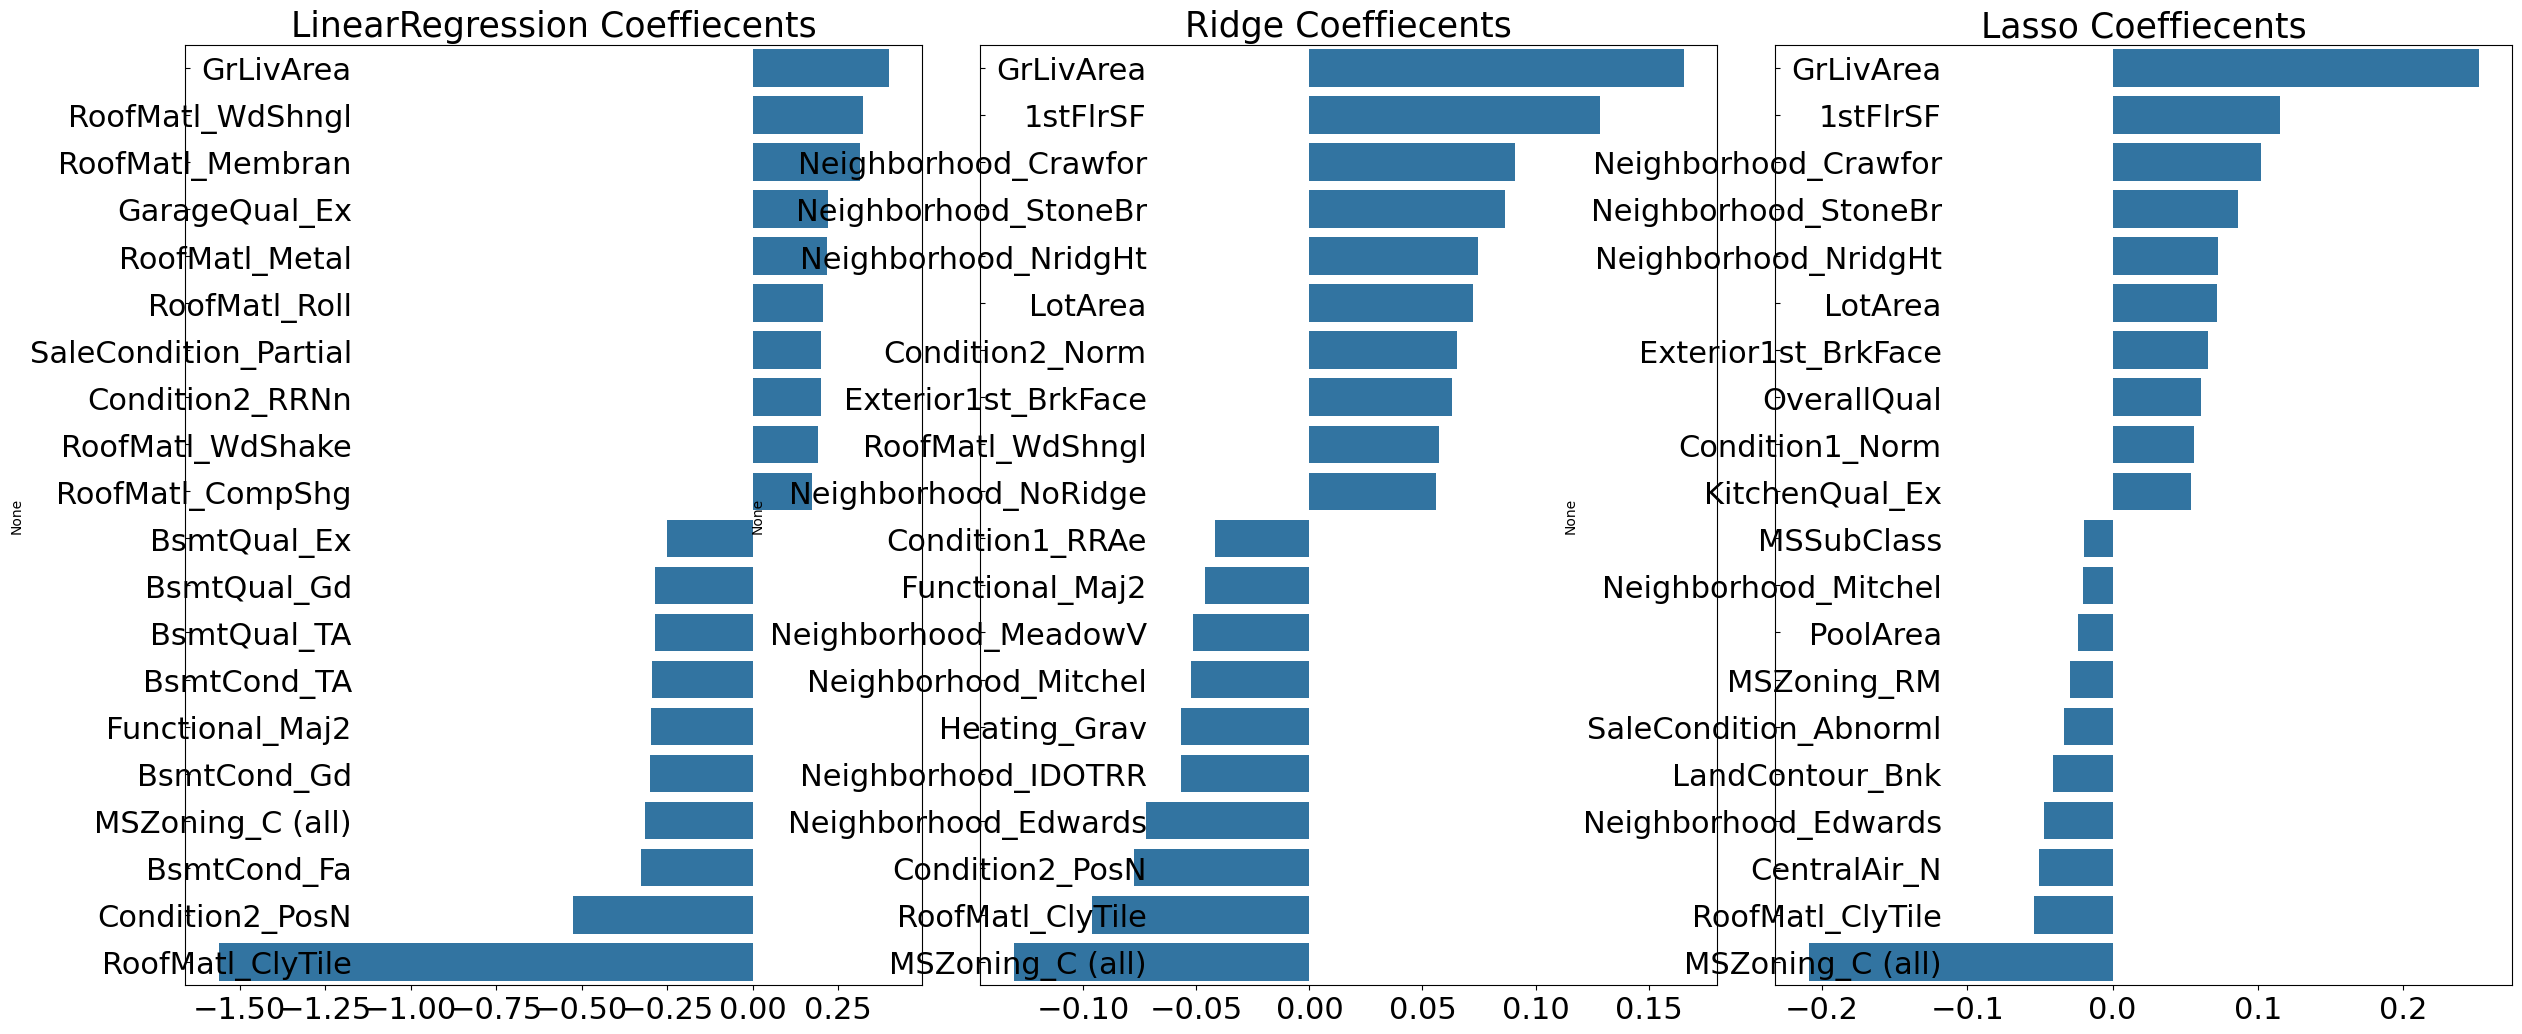

In [50]:
# 앞의 최적화 alpha값으로 학습데이터로 학습, 테스트 데이터로 예측 및 평가 수행.
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=10)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

# 모든 모델의 회귀 계수 시각화
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

- 세 모델 모두 GrLivArea(주거 공간 크기) 회귀 계수가 가장 높은 피처가 됨
- 주거 공간의 크기가 주택 가격에 미치는 영향이 제일 높을 것이라는 결과

이상치 제거
- 회귀 계수가 높은 피처(예측에 많은 영향을 미치는 중요 피처)의 이상치 데이터 처리가 중요
- 예제에서는 GrLivArea 피처의 데이터 분포 살펴보기

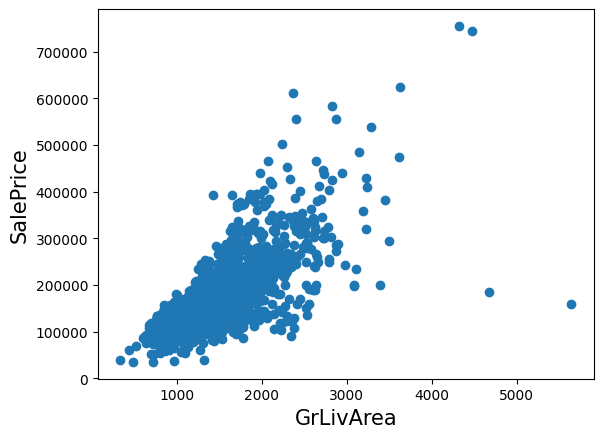

In [51]:
# 원본 데이터 세트에서 GrLiveArea와 타깃 값 SalePrice 관계 시각화
plt.scatter(x = house_df_org['GrLivArea'], y = house_df_org['SalePrice'])
plt.ylabel('SalePrice', fontsize=15)
plt.xlabel('GrLivArea', fontsize=15)
plt.show()

- GrLivArea가 가장 큰 두 데이터 가격이 매우 낮아 이상치로 간주

데이터 변환이 모두 완료된 `house_df_ohe`에서 대상 데이터를 필터링

In [52]:
# GrLivArea와 SalePrice 모두 로그 변환되었으므로 이를 반영한 조건 생성.
cond1 = house_df_ohe['GrLivArea'] > np.log1p(4000)  # 4000평방피트 이상
cond2 = house_df_ohe['SalePrice'] < np.log1p(500000)  # 500,000달러 이하
outlier_index = house_df_ohe[cond1 & cond2].index

print('아웃라이어 레코드 index :', outlier_index.values)
print('아웃라이어 삭제 전 house_df_ohe shape:', house_df_ohe.shape)

# DataFrame의 index를 이용하여 아웃라이어 레코드 삭제.
house_df_ohe.drop(outlier_index , axis=0, inplace=True)
print('아웃라이어 삭제 후 house_df_ohe shape:', house_df_ohe.shape)

아웃라이어 레코드 index : [ 523 1298]
아웃라이어 삭제 전 house_df_ohe shape: (1460, 270)
아웃라이어 삭제 후 house_df_ohe shape: (1458, 270)


- 이상치는 레코드 인덱스 523, 1298이 대상
- 두 개의 데이터 삭제해 전체 레코드 1460개에서 1458개로 감소

업데이트된 `house_df_ohe` 기반으로 피처 데이터 세트와 타깃 데이터 세트 다시 생성하고 `print_best_params()` 함수 이용해 릿지와 라쏘 모델의 최적화 수행 및 결과 출력

In [53]:
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice',axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }
best_ridge = print_best_params(ridge_reg, ridge_params)
best_lasso = print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값: 0.1125, 최적 alpha:{'alpha': 8}
Lasso 5 CV 시 최적 평균 RMSE 값: 0.1122, 최적 alpha:{'alpha': 0.001}


- 예측 수치 크게 향상
- 릿지 모델 최적 alpha 값 12 -> 8, 평균 RMSE 0.1252 -> 0.1122
- 라쏘 모델 최적 alpha 값  0.001, 평균 RMSE 0.128 -> 0.114
- GrLivArea 속성이 회귀 모델에서 차지하는 영향도가 크기에 이 이상치를 개선하는 것이 성능 개선에 큰 의미 가짐

이상치 제거된 데이터 세트 기반으로 다시 `train_test_split()`로 분할된 데이터 세트의 RMSE 수치 및 회귀 계수 시각화

LinearRegression 로그 변환된 RMSE: 0.129
Ridge 로그 변환된 RMSE: 0.103
Lasso 로그 변환된 RMSE: 0.1


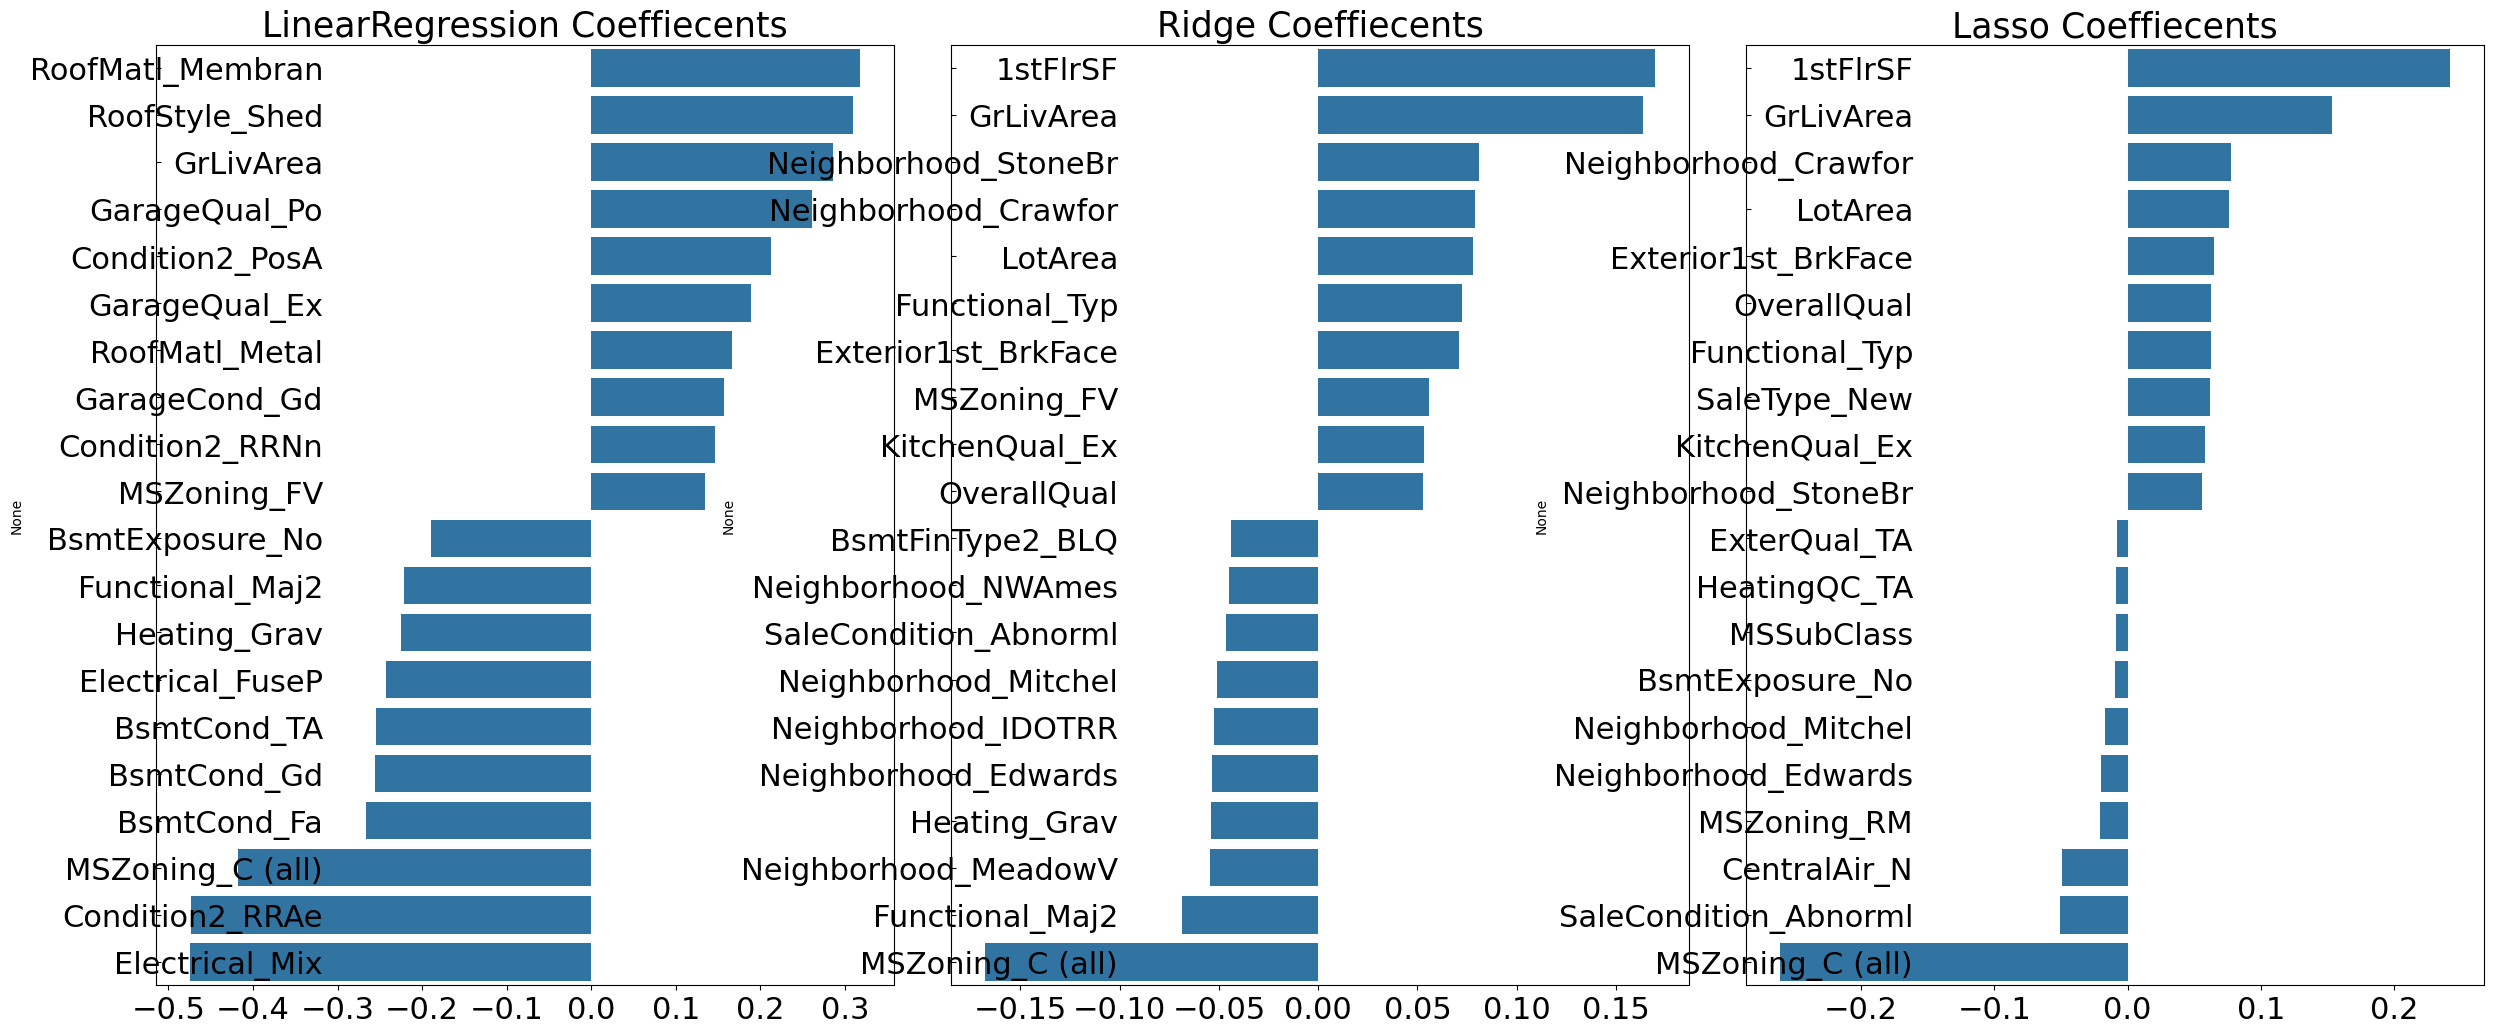

In [54]:
# 앞의 최적화 alpha값으로 학습데이터로 학습, 테스트 데이터로 예측 및 평가 수행.
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=8)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

# 모든 모델의 회귀 계수 시각화
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

### 회귀 트리 학습/예측/평가

XGBoost, LightGBM 모두 수행 시간 오래 걸리므로 하이퍼 파라미터 설정 미리 적용한 상태로 5 폴드 세트에 대한 평균 RMSE값 구하기

In [55]:
from xgboost import XGBRegressor

xgb_params = {'n_estimators':[1000]}
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05,
                       colsample_bytree=0.5, subsample=0.8)
best_xgb = print_best_params(xgb_reg, xgb_params)

XGBRegressor 5 CV 시 최적 평균 RMSE 값: 0.1185, 최적 alpha:{'n_estimators': 1000}


In [56]:
from lightgbm import LGBMRegressor

lgbm_params = {'n_estimators':[1000]}
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4,
                         subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
best_lgbm = print_best_params(lgbm_reg, lgbm_params)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002147 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3155
[LightGBM] [Info] Number of data points in the train set: 1166, number of used features: 171
[LightGBM] [Info] Start training from score 12.021352
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000842 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3167
[LightGBM] [Info] Number of data points in the train set: 1166, number of used features: 168
[LightGBM] [Info] Start training from score 12.023516
[LightGBM] [Warning] Found

모델의 피처 중요도 시각화

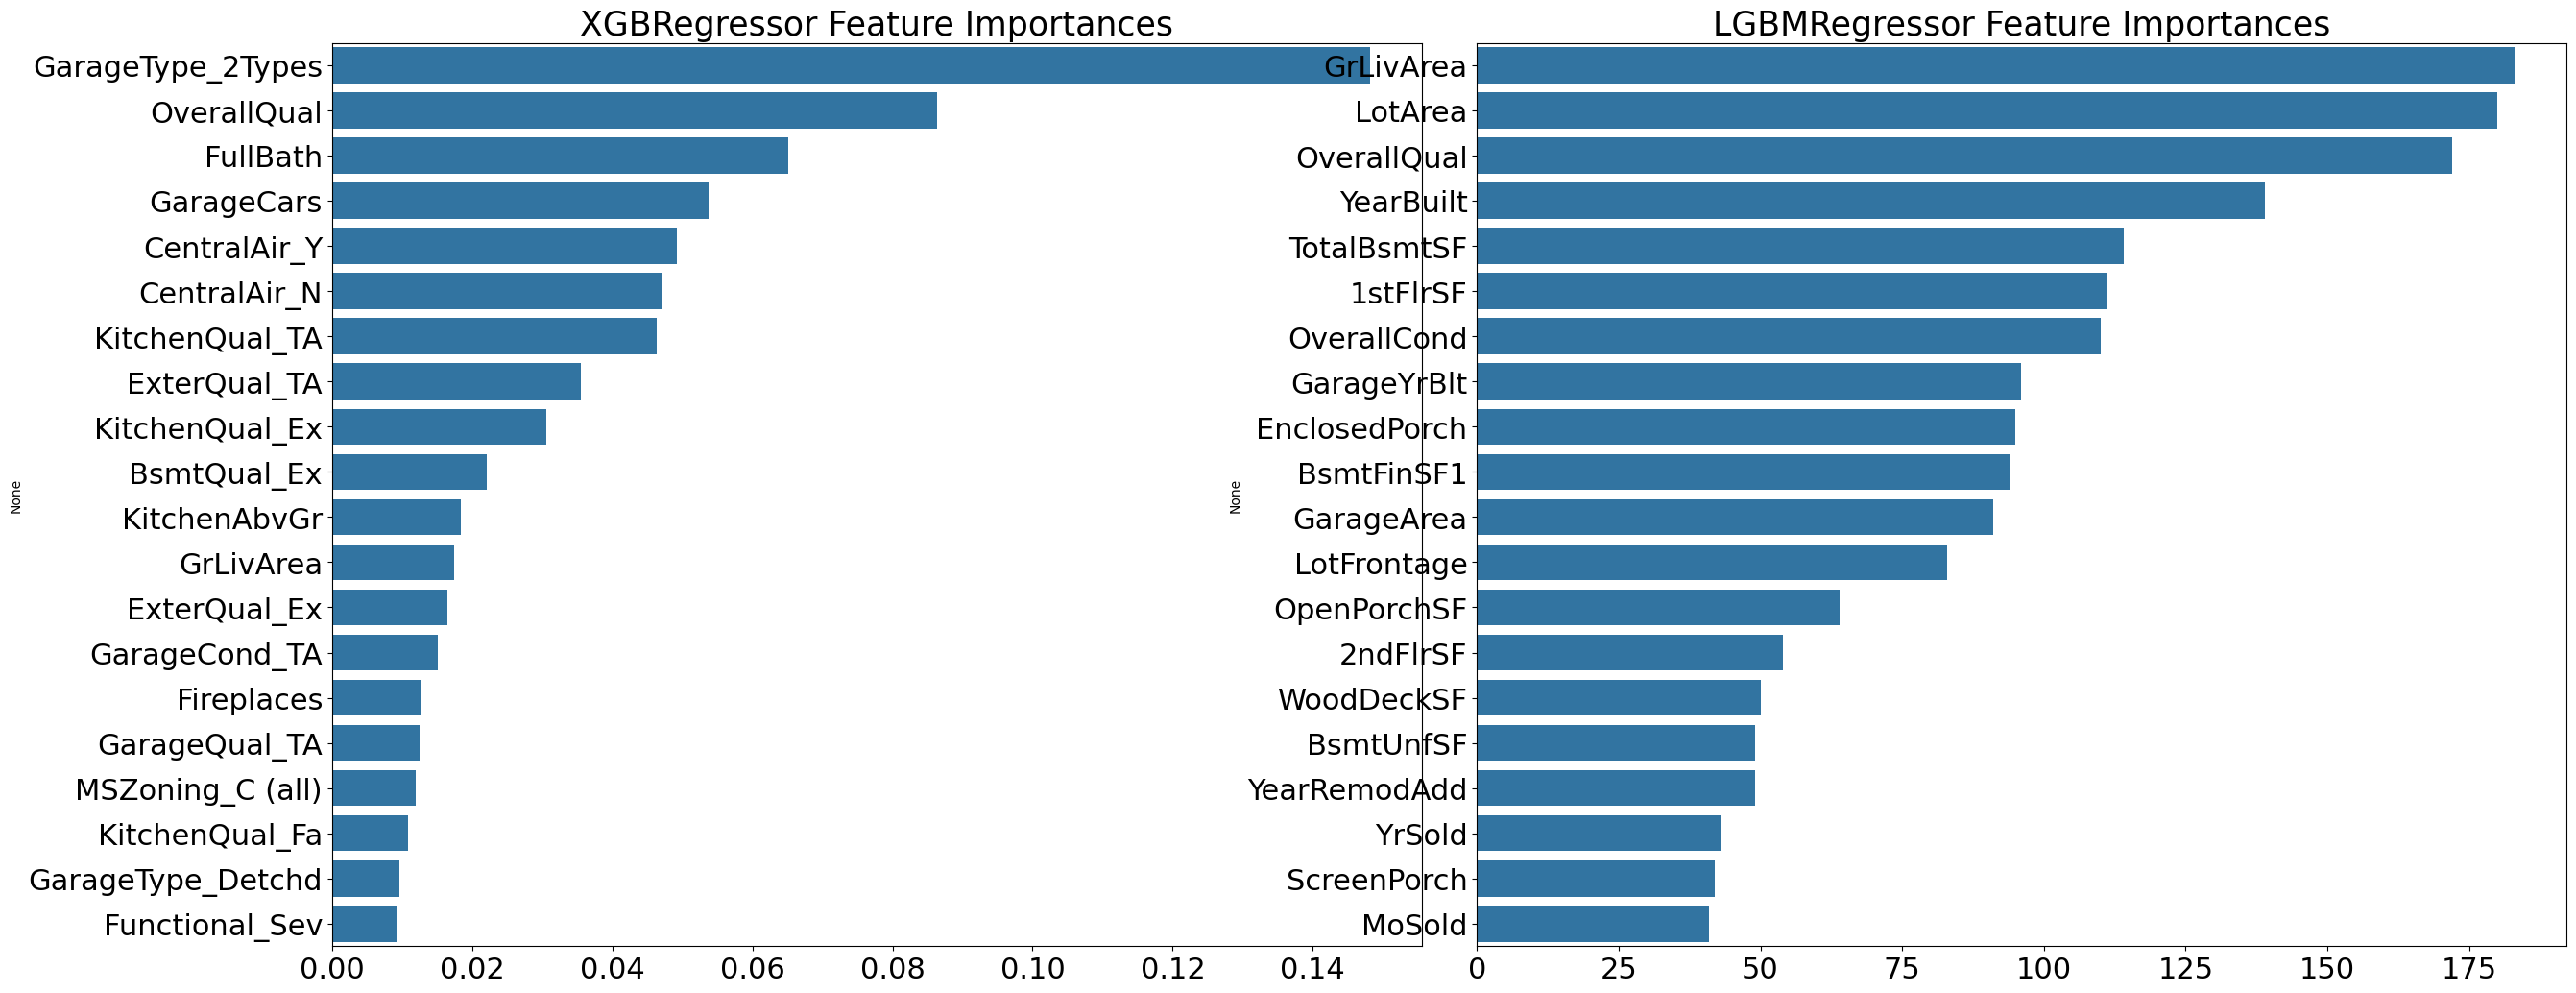

In [57]:
# 모델의 중요도 상위 20개의 피처명과 그때의 중요도값을 Series로 반환.
def get_top_features(model):
    ftr_importances_values = model.feature_importances_
    ftr_importances = pd.Series(ftr_importances_values, index=X_features.columns  )
    ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]
    return ftr_top20

def visualize_ftr_importances(models):
    # 2개 회귀 모델의 시각화를 위해 2개의 컬럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize=(24,10),nrows=1, ncols=2)
    fig.tight_layout()
    # 입력인자로 받은 list객체인 models에서 차례로 model을 추출하여 피처 중요도 시각화.
    for i_num, model in enumerate(models):
        # 중요도 상위 20개의 피처명과 그때의 중요도값 추출
        ftr_top20 = get_top_features(model)
        axs[i_num].set_title(model.__class__.__name__+' Feature Importances', size=25)
        #font 크기 조정.
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=ftr_top20.values, y=ftr_top20.index , ax=axs[i_num])

# 앞 예제에서 print_best_params( )가 반환한 GridSearchCV로 최적화된 모델의 피처 중요도 시각화
models = [best_xgb, best_lgbm]
visualize_ftr_importances(models)

### 회귀 모델들의 예측 결과 혼합을 통한 최종 예측

개별 회귀 모델의 예측 결괏값을 혼합해 이를 기반으로 최종 회귀 값 예측
- 릿지 모델과 라쏘 모델 서로 혼합

In [58]:
# 최종 혼합 모델, 개별 모델의 RMSE 값을 출력하는 함수
def get_rmse_pred(preds):
    for key in preds.keys():
        pred_value = preds[key]
        mse = mean_squared_error(y_test , pred_value)
        rmse = np.sqrt(mse)
        print('{0} 모델의 RMSE: {1}'.format(key, rmse))

# 개별 모델의 학습
ridge_reg = Ridge(alpha=8)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)
# 개별 모델 예측
ridge_pred = ridge_reg.predict(X_test)
lasso_pred = lasso_reg.predict(X_test)

# 개별 모델 예측값 혼합으로 최종 예측값 도출
# 릿지 모델 예측값의 40%, 라쏘 모델 예측값의 60% <- 특별한 기준 없고, 두 개 중 성능 조금 좋은 쪽에 가중치
pred = 0.4 * ridge_pred + 0.6 * lasso_pred
preds = {'최종 혼합': pred,
         'Ridge': ridge_pred,
         'Lasso': lasso_pred}
#최종 혼합 모델, 개별모델의 RMSE 값 출력
get_rmse_pred(preds)

최종 혼합 모델의 RMSE: 0.10006075517615194
Ridge 모델의 RMSE: 0.10340697165289348
Lasso 모델의 RMSE: 0.10024171179335342


- 최종 혼합 모델의 RMSE가 개별 모델보다 성능 면에서 약간 개선됨

XGBoost와 LightGBM 혼합

In [59]:
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05,
                       colsample_bytree=0.5, subsample=0.8)
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4,
                         subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
xgb_reg.fit(X_train, y_train)
lgbm_reg.fit(X_train, y_train)
xgb_pred = xgb_reg.predict(X_test)
lgbm_pred = lgbm_reg.predict(X_test)

pred = 0.5 * xgb_pred + 0.5 * lgbm_pred
preds = {'최종 혼합': pred,
         'XGBM': xgb_pred,
         'LGBM': lgbm_pred}

get_rmse_pred(preds)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000833 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3174
[LightGBM] [Info] Number of data points in the train set: 1166, number of used features: 172
[LightGBM] [Info] Start training from score 12.025343
최종 혼합 모델의 RMSE: 0.10208933384486087
XGBM 모델의 RMSE: 0.10749463285555907
LGBM 모델의 RMSE: 0.10363891833477148


- 최종 혼합 모델의 RMSE가 개별 모델보다 성능 면에서 약간 개선됨

### 스태킹 모델을 통한 회귀 예측

스태킹 모델
- 개별 기반 모델
- 최종 메타 모델: 개별 기반 모델의 예측 데이터를 학습 데이터로 만들어서 학습
- 여러 개별 모델의 예측 데이터를 각각 스태킹 형태로 결합해 최종 메타 모델의 학습용 피처 데이터 세트와 테스트용 피처 데이터 세트를 만드는 것

In [60]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수.
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds ):
    # 지정된 n_folds값으로 KFold 생성.
    kf = KFold(n_splits=n_folds, shuffle=False)
    #추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화
    train_fold_pred = np.zeros((X_train_n.shape[0] ,1 ))
    test_pred = np.zeros((X_test_n.shape[0],n_folds))
    print(model.__class__.__name__ , ' model 시작 ')

    for folder_counter , (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        #입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 셋 추출
        print('\t 폴드 세트: ',folder_counter,' 시작 ')
        X_tr = X_train_n[train_index]
        y_tr = y_train_n[train_index]
        X_te = X_train_n[valid_index]

        #폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행.
        model.fit(X_tr , y_tr)
        #폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장.
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
        #입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장.
        test_pred[:, folder_counter] = model.predict(X_test_n)

    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)

    #train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred , test_pred_mean

`get_stacking_base_datasets()` 모델별로 적용해 메타 모델이 사용할 학습 피처 데이터 세트와 테스트 데이터 세트를 추출
- 적용할 개별 모델은 릿지, 라쏘, XGBoost, LightGBM
- 함수 인자로 개별 기반 모델, 원래 사용되는 학습 데이터와 테스트용 피처 데이터 입력 받음
- 함수 내에서 개별 모델이 K-폴드 세트로 설정된 폴드 세트 내부에서 원본 학습 데이터 다시 추출해 학습과 예측 수행한 뒤 그 결과 저장
- 저장된 예측 데이터는 추후 메타 모델의 학습 피처 데이터 세트
- 원본 테스트 데이터 예측 결과를 평균해 테스트 데이터 생성

In [61]:
# get_stacking_base_datasets( )은 넘파이 ndarray를 인자로 사용하므로 DataFrame을 넘파이로 변환.
X_train_n = X_train.values
X_test_n = X_test.values
y_train_n = y_train.values

# 각 개별 기반(Base)모델이 생성한 학습용/테스트용 데이터 반환.
ridge_train, ridge_test = get_stacking_base_datasets(ridge_reg, X_train_n, y_train_n, X_test_n, 5)
lasso_train, lasso_test = get_stacking_base_datasets(lasso_reg, X_train_n, y_train_n, X_test_n, 5)
xgb_train, xgb_test = get_stacking_base_datasets(xgb_reg, X_train_n, y_train_n, X_test_n, 5)
lgbm_train, lgbm_test = get_stacking_base_datasets(lgbm_reg, X_train_n, y_train_n, X_test_n, 5)

Ridge  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
Lasso  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
XGBRegressor  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
LGBMRegressor  model 시작 
	 폴드 세트:  0  시작 
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000829 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2924
[LightGBM] [Info] Number of data points in the train set: 932, number of used features: 156
[LightGBM] [Info] Start training from score 12.035561
	 폴드 세트:  1  시작 
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000942 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=tru

각 개별 모델이 반환하는 학습용 피처 데이터와 테스트용 피처 데이터 세트를 결합해 최종 메타 모델에 적용

In [62]:
# 개별 모델이 반환한 학습 및 테스트용 데이터 세트를 Stacking 형태로 결합.
Stack_final_X_train = np.concatenate((ridge_train, lasso_train,
                                      xgb_train, lgbm_train), axis=1)
Stack_final_X_test = np.concatenate((ridge_test, lasso_test,
                                     xgb_test, lgbm_test), axis=1)

# 최종 메타 모델은 라쏘 모델을 적용.
meta_model_lasso = Lasso(alpha=0.0005)

#기반 모델의 예측값을 기반으로 새롭게 만들어진 학습 및 테스트용 데이터로 예측하고 RMSE 측정.
meta_model_lasso.fit(Stack_final_X_train, y_train)
final = meta_model_lasso.predict(Stack_final_X_test)
mse = mean_squared_error(y_test , final)
rmse = np.sqrt(mse)
print('스태킹 회귀 모델의 최종 RMSE 값은:', rmse)

스태킹 회귀 모델의 최종 RMSE 값은: 0.09762120850917913


- RMSE가 약 0.0979로 현재까지 가장 좋은 성능 평가 보여줌
- 스태킹 모델은 분류뿐만 아니라 회귀에서 특히 효과적으로 사용될 수 있는 모델